# Discrete Fourier Transform (DFT), in Practice

This notebook will guide you through some basic usage of the Fourier Transform, in practice.

The objectives are:
1. Introduce the Short-time Fourier Transform (STFT).
2. Investigate what effect the different STFT parameters have on the resulting spectrogram.
3. Allow you to play around with the parameters on your own.

First, we will import the packages we need.

In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

## Create a basic sine wave

First, we will create a very basic sine wave in an array, and view it.

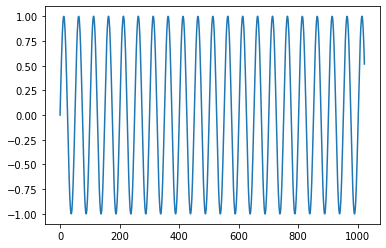

In [2]:
# Function to generate a sine wave
def generate_sine_wave(N, sr, freq):
    """
    Generate a sine wave with the given number of samples, sample-rate, and frequency.
    
    Parameters
    ----------
    N : int
         The number of samples to return.
         
    sr : int
         The sample-rate for the returned signal, in Hz.
         
    freq : float
        The frequency for the returned signal, in Hz.
        
    Returns
    -------
    x : np.array(float)
        N samples of a sine wave with frequency freq, sampled at sr Hz.
    """
    return np.sin(np.arange(N) * 2 * np.pi * freq / sr)


# Number of samples in signal
N = 2 ** 10

# Sample rate of signal (Hz)
sr = 22050

# Frequency of sine wave (Hz)
freq = 440

# Generate the sine wave
x = generate_sine_wave(N, sr, freq)

# View signal
plt.plot(x)
Audio(x, rate=sr)

## Short-time Fourier Transform (STFT)

The DFT operates on the entire length of a signal, but we usually want to see how that signal changes over time. The STFT solves that problem.

1. Create some "window" function, which is non-zero only for a short period of time.  
There are many different window functions. One basic one is the Hanning window.  
See more window types here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window  
Important is the "frequency response" when viewing a window. This is the expected result for detecting the presence of a sine wave.

2. Slide the window along the input signal, multiplying the window function by (overlapping) parts of the signal.

3. 0-pad the windowed signal (usually to reach a power of 2 size).

4. Run the standard DFT on each padded windowed slice of the signal.

5. Result: Spectrogram!

### Example of the Hanning window

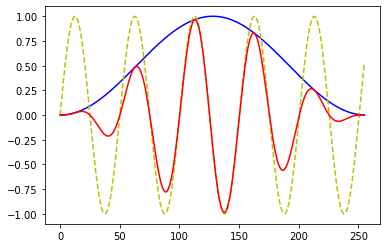

In [3]:
# Hanning window
length = 256
window = signal.get_window('hanning', length)

plt.plot(window, 'b') # Blue
plt.plot(x[:length], 'y--') # Yellow
plt.plot(window * x[:length], 'r') # Red

### Simple STFT Code Example
Here, we create a longer sine wave, and run the STFT for the first time.

For now, we will just run the STFT with default settings. We will investigate the important parameters later.

In [4]:
# Create basic 440 Hz sine wave
sr = 22050
freq = 440
N = 2 ** 12
x = generate_sine_wave(N, sr, freq)

# Perform STFT
_, _, X = signal.stft(x,                  # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=256,        # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (after 0-padding, default: nperseg)

print(f"X.shape = {X.shape} (freq, time)")

# How to get magnitude and phase
magnitude = np.abs(X)
phase = np.angle(X)

X.shape = (129, 33) (freq, time)


### Questions

Why is X that shape?

Why isn't freq = nperseg?
  - Nyquist frequency, half of X is just a reflection.

### Invertibility
The STFT is also invertible, if you know the correct parameters.

All close? True


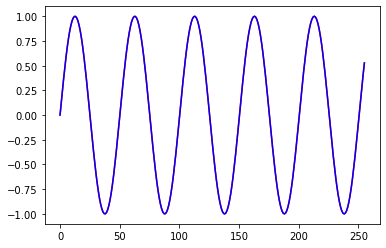

In [5]:
_, x_inverted = signal.istft(X,
                             fs=sr,              # Sample rate (Frequency of Sampling)
                             window='hann')      # Window shape

print("All close? " + str(np.allclose(x, x_inverted)))
plt.plot(x[:256], 'r')
plt.plot(x_inverted[:256], 'b')

## STFT Plotting

This is our basic STFT plotting function. The min/max bounds can be used to zoom in on particular spots in the spectrogram. For now, we will just plot our STFT as is, and see how it looks.

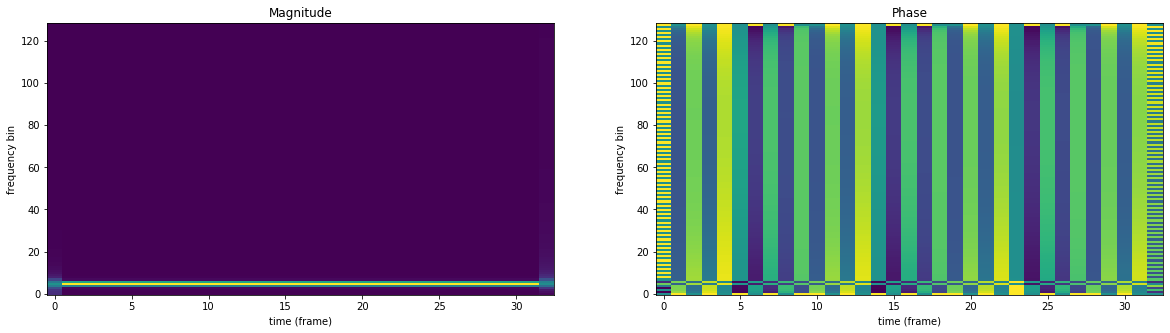

In [6]:
def plot_stft(X, f=None, t=None, f_min=None, f_max=None, t_min=None, t_max=None, log_freq=False):
    """
    Plot the phase and magnitude of a given stft result.
    
    Parameters
    ----------
    X : np.ndarray
        The stft result, complex values.
        
    f : np.array
        A list of the frequencies (Hz) corresponding to the first axis of the stft result,
        if known.
        
    t : np.array
        A list of the times (s) corresponding to the second axis of the stft result,
        if known.
        
    f_min : float
        The minimum frequency to be displayed in the plot. This will be clipped to min(f).
        
    f_max : float
        The maximum frequency to be displayed in the plot. This will be clipped to max(f).
        
    t_min : float
        The minimum time to be displayed in the plot. This will be clipped to min(t).
        
    t_max : float
        The maximum time to be displayed in the plot. This will be clipped to max(t).
        
    log_freq : boolean
        Set the frequence axis to log scale.
    """
    ###################
    # Parse input
    ###################
    
    # Set up f and t as simple ranges if not given
    f_given = not f is None
    t_given = not t is None
    if f is None:
        f = np.arange(X.shape[0] + 1) - 0.5
    else:
        f = np.append([f[0] - (f[1] - f[0])], f) + ((f[1] - f[0]) / 2)
    if t is None:
        t = np.arange(X.shape[1] + 1) - 0.5
    else:
        t = np.append([t[0] - (t[1] - t[0])], t) + ((t[1] - t[0]) / 2)
    
    
    ##################
    # Get magnitude and phase of result
    ##################
    
    magnitude = np.abs(X)
    phase = np.angle(X)
    
    
    ###################
    # PLOTTING
    ###################
    
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(20,5))
    
    # Plot magnitude
    axs[0].pcolormesh(t, f, magnitude)
    axs[0].set_title("Magnitude")
    axs[0].set_xlabel(f"time ({'s' if t_given else 'frame'})")
    axs[0].set_ylabel(f"frequency {'(Hz)' if f_given else 'bin'}")
    axs[0].set_ylim(f_min, f_max)
    axs[0].set_xlim(t_min, t_max)
    if log_freq:
        axs[0].set_yscale('log')
    
    # Plot phase
    axs[1].pcolormesh(t, f, phase)
    axs[1].set_title("Phase")
    axs[1].set_xlabel(f"time ({'s' if t_given else 'frame'})")
    axs[1].set_ylabel(f"frequency {'(Hz)' if f_given else 'bin'}")
    axs[1].set_ylim(f_min, f_max)
    axs[1].set_xlim(t_min, t_max)
    if log_freq:
        axs[1].set_yscale('log')
    
    fig.show()

plot_stft(X)

## Improving the STFT Plot
- What can we see from this most basic plot?
- What information do we need?
   - frequencies, times
   - zoom in

t = [0.         0.00580499 0.01160998 0.01741497 0.02321995 0.02902494
 0.03482993 0.04063492 0.04643991 0.0522449  0.05804989 0.06385488
 0.06965986 0.07546485 0.08126984 0.08707483 0.09287982 0.09868481
 0.1044898  0.11029478 0.11609977 0.12190476 0.12770975 0.13351474
 0.13931973 0.14512472 0.15092971 0.15673469 0.16253968 0.16834467
 0.17414966 0.17995465 0.18575964]
f = [    0.           86.1328125   172.265625    258.3984375   344.53125
   430.6640625   516.796875    602.9296875   689.0625      775.1953125
   861.328125    947.4609375  1033.59375    1119.7265625  1205.859375
  1291.9921875  1378.125      1464.2578125  1550.390625   1636.5234375
  1722.65625    1808.7890625  1894.921875   1981.0546875  2067.1875
  2153.3203125  2239.453125   2325.5859375  2411.71875    2497.8515625
  2583.984375   2670.1171875  2756.25       2842.3828125  2928.515625
  3014.6484375  3100.78125    3186.9140625  3273.046875   3359.1796875
  3445.3125     3531.4453125  3617.578125   3703.7109375  378

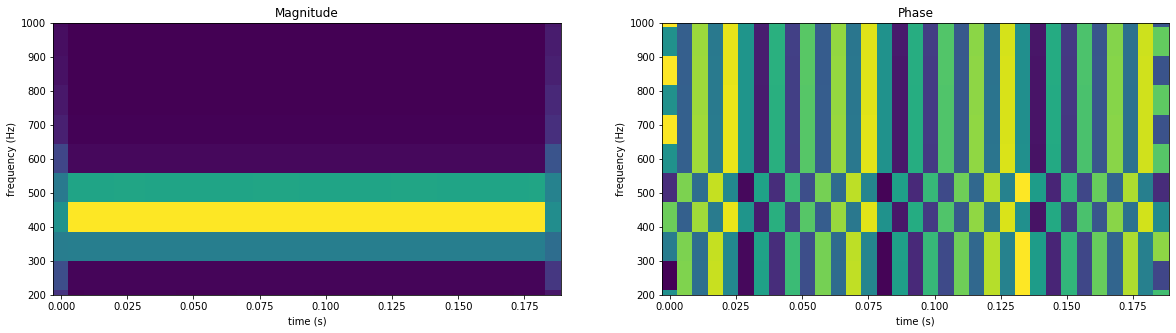

In [7]:
# Generate the times list t
step_time = 128 / sr   # 128 is the window step length (nperseg - noverlap)
t = np.arange(X.shape[1]) * step_time
print(f"t = {t}")

# Generate frequencies list f
# The integer frequency rows are measured in "cycles per window"
# The ith row contains the magnitude of the sine wave which has i cycles per window
# 1 window is (256 / sr) seconds long, so the frequency of the ith row is 1 / (256 / sr)
freq_gap = sr / 256    # 256 is the window size
                       # So, sr samples/sec divided by 256 samples
f = np.arange(X.shape[0]) * freq_gap
print(f"f = {f}")


# We can also get these results from the stft function, but it is good to know how they are calculated!
# f, t, X = signal.stft(...)

# Plot resulting spectrogram (we'll also zoom in here on 440Hz using f_min and f_max)
plot_stft(X, f=f, t=t, f_min=200, f_max=1000)

We need better frequency resolution! How?
  - Larger window?

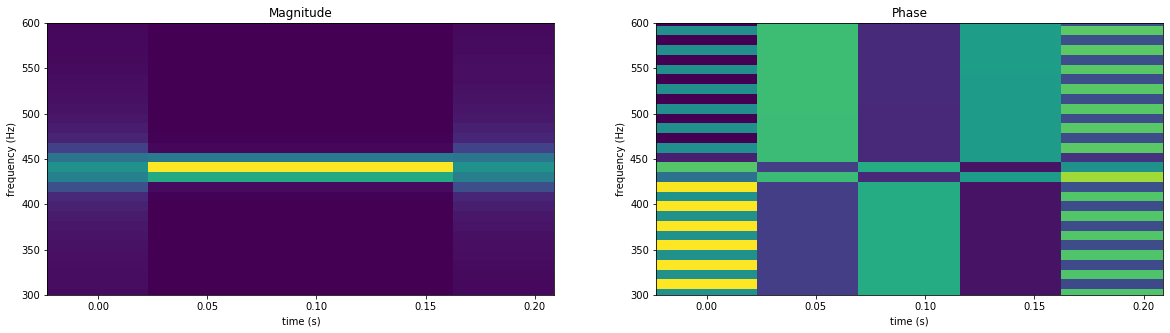

In [8]:
# Basic 440 Hz sine wave
sr = 22050
freq = 440
N = 2 ** 12
x = generate_sine_wave(N, sr, freq)

# Perform STFT
f, t, X = signal.stft(x,                  # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=2048,       # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=300, f_max=600)

Better, but now worse time resolution!

Try changing nperseg, noverlap, and nfft. Can you get better time and/or frequency resolution? At what cost?

## Now try with a more complicated signal

In [9]:
# One second chirp
x_upwards = signal.chirp(np.arange(2 * sr) / sr, 220, 2, 880)
x_downwards = signal.chirp(np.arange(2 * sr) / sr, 880, 2, 220)
x_sum = x_upwards + x_downwards

In [10]:
Audio(x_upwards, rate=sr)

In [11]:
Audio(x_downwards, rate=sr)

In [12]:
Audio(x_sum, rate=sr)

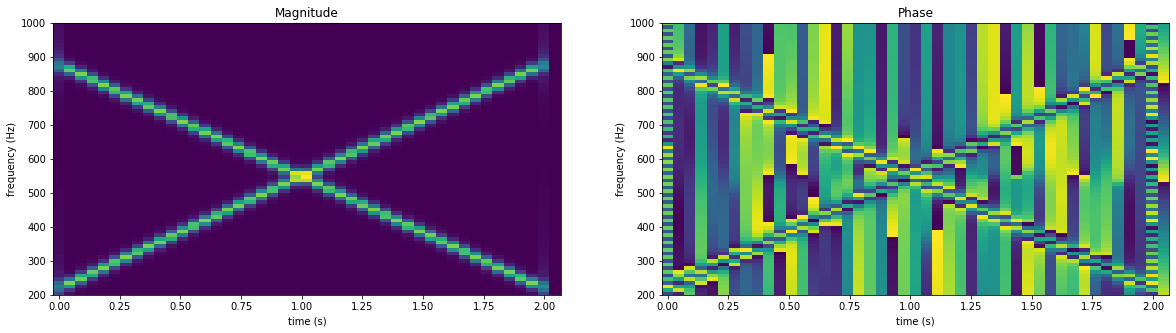

In [13]:
# Perform STFT
f, t, X = signal.stft(x_sum,              # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=2048,       # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=200, f_max=1000)

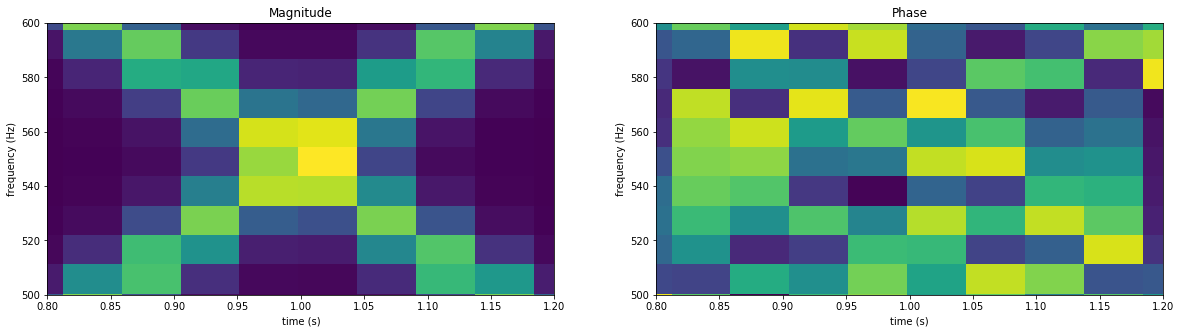

In [14]:
# Perform STFT
f, t, X = signal.stft(x_sum,              # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=2048,       # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=500, f_max=600, t_min=0.8, t_max=1.2)

### Square wave and sawtooth wave

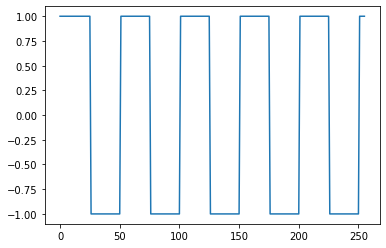

In [15]:
# Square wave, 440 Hz
x_square = signal.square(np.arange(2 * sr) / sr * 2 * np.pi * 440)
plt.plot(x_square[:256])
Audio(x_square * 0.05, rate=sr, normalize=False)

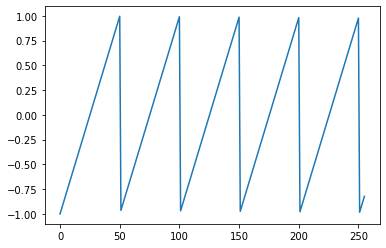

In [16]:
# Sawtooth wave, 440 Hz
x_sawtooth = signal.sawtooth(np.arange(2 * sr) / sr * 2 * np.pi * 440)
plt.plot(x_sawtooth[:256])
Audio(x_sawtooth * 0.05, rate=sr, normalize=False)

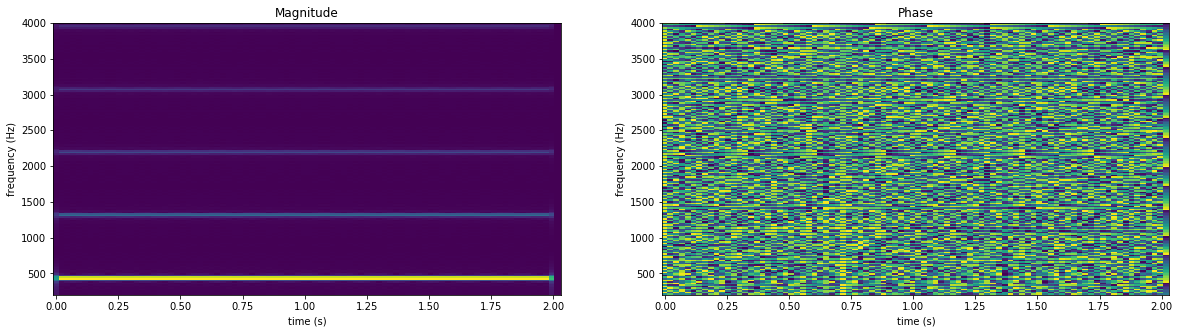

In [17]:
# Square wave
f, t, X = signal.stft(x_square,           # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=1024,       # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=200, f_max=4000)

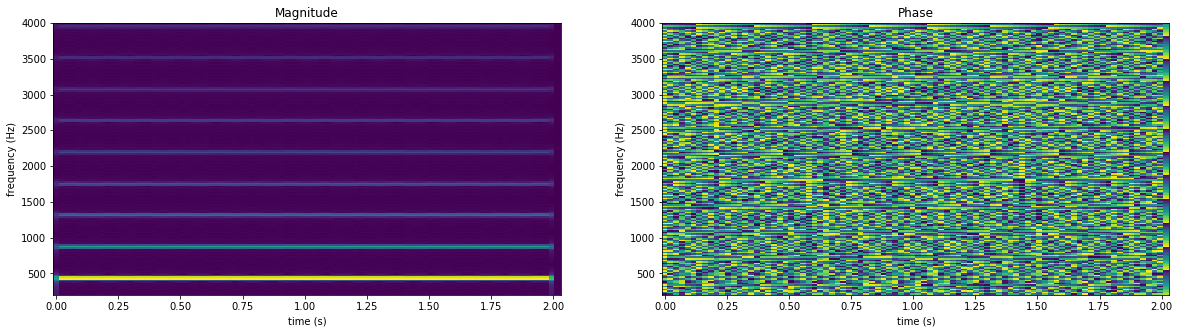

In [18]:
# Perform STFT
f, t, X = signal.stft(x_sawtooth,         # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=1024,       # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=200, f_max=4000)

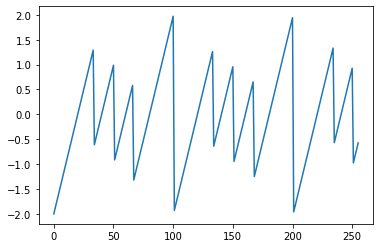

In [19]:
# Dual sawtooth, 440 Hz and 659 Hz (perfect 5th)
x_sawtooth_440 = signal.sawtooth(np.arange(2 * sr) / sr * 2 * np.pi * 440)
x_sawtooth_659 = signal.sawtooth(np.arange(2 * sr) / sr * 2 * np.pi * 659.26)
x_sawtooth_sum = x_sawtooth_440 + x_sawtooth_659
plt.plot(x_sawtooth_sum[:256])
Audio(x_sawtooth_sum * 0.05, rate=sr, normalize=False)

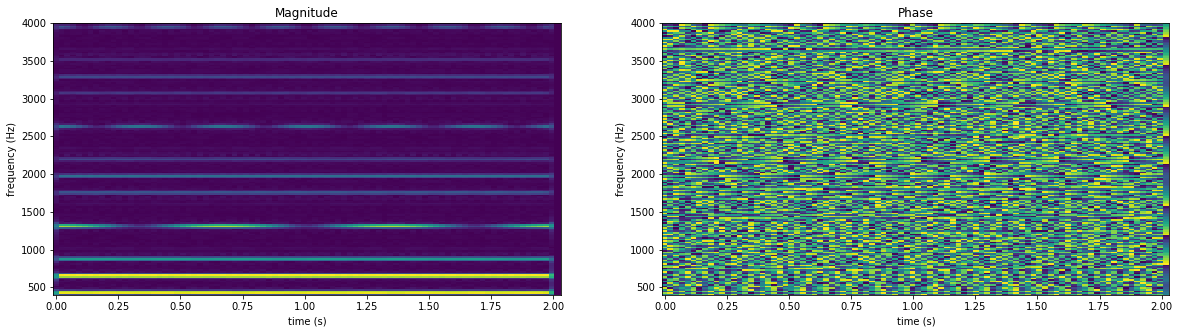

In [20]:
# Perform STFT
f, t, X = signal.stft(x_sawtooth_sum,     # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=1024,        # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=400, f_max=4000)

## Final Notes

- Log scale frequency benefits.
- Other STFT extensions.

### Log-scale frequency

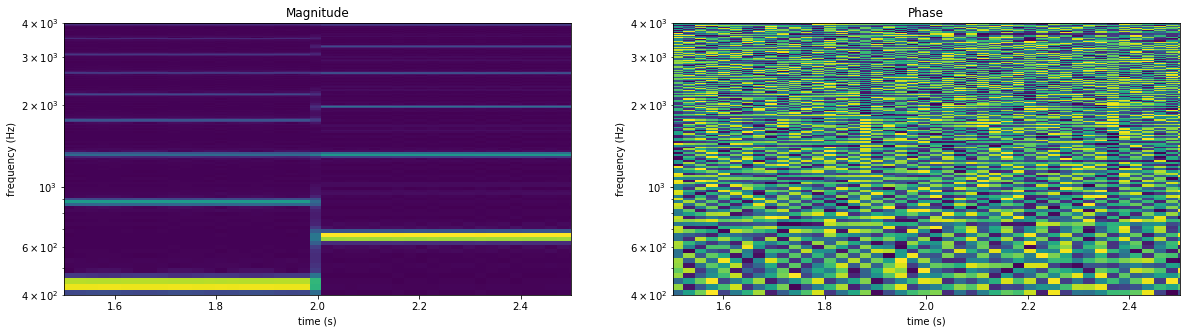

In [21]:
# Perform STFT
f, t, X = signal.stft(np.append(x_sawtooth_440, x_sawtooth_659),     # Input signal
                      fs=sr,              # Sample rate (Frequency of Sampling)
                      window='hann',      # Window shape
                      nperseg=1024,        # Window length
                      noverlap=None,      # How much overlap per window (default: nperseg / 2)
                      nfft=None)          # Length of fft (can pad with zeros, default: nperseg)

plot_stft(X, f=f, t=t, f_min=400, f_max=4000, t_min=1.5, t_max=2.5, log_freq=True)

Benefit:
- Allows for each note to look the same, regardless of frequency.

### Constant-Q Transform (CQT)
We will do this with [librosa](https://librosa.github.io/librosa/). Librosa is a package for audio processing specifically designed for music.

A Constant-Q transform uses a different size window depending on the frequency so that the frequency resolution is generally the same no matter what frequency we are looking at.

In [22]:
import librosa

In [23]:
X = librosa.core.cqt(np.append(x_sawtooth_440, x_sawtooth_659),
                     sr=sr,
                     hop_length=512,
                     bins_per_octave=12,
                     n_bins=100,
                     fmin=27.5)

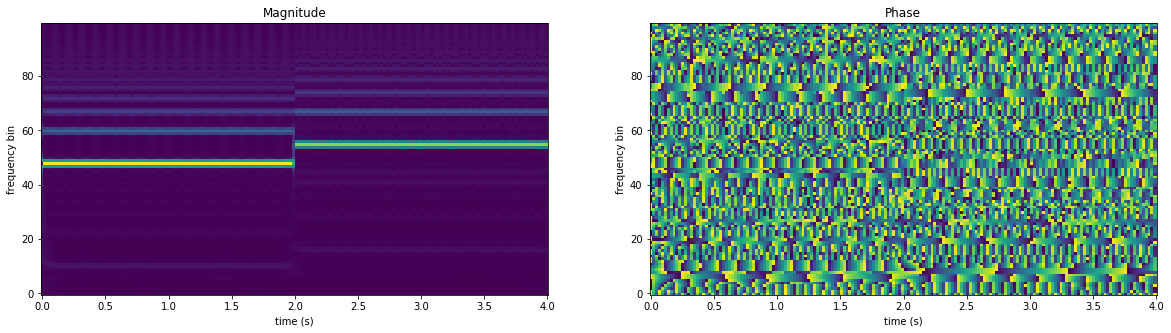

In [24]:
plot_stft(X, t=np.arange(X.shape[1]) / sr * 512)

### Final Thoughts
There are many more ways to get a spectrogram (VQT, MFCC, ...), but they all generally work by tweaking the basic STFT to give you slightly different results, depending on your use case.